# Robust Linear Regression

This is a linear regression with a Student-T distribution for the error model.

In [92]:
import numpy as np
import scipy

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt

import pystan

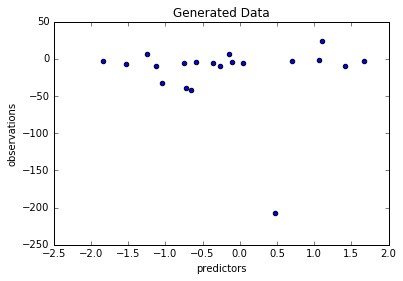

In [115]:
N = 20
predictors = np.random.randn(N)
noise = scipy.stats.t.rvs(df=1, size=N, scale=4.0)
observations = 2.0 * predictors - 1.5 + noise

fig, ax = plt.subplots(1,1)
ax.set_title('Generated Data')
ax.set_xlabel('predictors')
ax.set_ylabel('observations')
ax.scatter(predictors, observations)
fig.show()

In [112]:
import pystan

In [95]:
model_code = """
data {
    real<lower=0> alpha_sigma;
    real<lower=0> beta_sigma;
    real<lower=0> sigma_sigma;

    real<lower=0> nu;

    int N;
    vector[N] x;
    vector[N] y;
}

parameters {
    real beta;
    real alpha;
    real<lower=0> sigma;
}

model {
    alpha ~ cauchy(0, alpha_sigma);
    beta  ~ cauchy(0, beta_sigma);
    sigma ~ cauchy(0, sigma_sigma);
    
    y ~ student_t(nu, beta * x + alpha, sigma);
}
"""
model = pystan.StanModel(model_code=model_code)

In [108]:
fit = model.sampling(data=dict(nu=1, N=N, x=predictors, y=observations, alpha_sigma=10, beta_sigma=10, sigma_sigma=10))
print fit

Inference for Stan model: anon_model_844359b2be33a9a3d86dd3979ff6531d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta    5.06    0.09   2.78   0.21   3.24   4.88   6.57  11.36  891.0    1.0
alpha  -1.77    0.05   1.48  -4.95  -2.64  -1.74  -0.86   1.12  904.0    1.0
sigma   4.89    0.07   2.07   2.03    3.4   4.47   5.96   9.93  785.0    1.0
lp__  -62.54    0.05    1.4  -66.0 -63.22 -62.22  -61.5 -60.86  734.0    1.0

Samples were drawn using NUTS(diag_e) at Thu Mar  3 15:02:14 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [109]:
samples = fit.extract()
alpha = samples['alpha'][:, np.newaxis]
beta  = samples['beta'][:, np.newaxis]
mx  = np.linspace(-3, 3)
yxx = np.outer(beta, mx) + alpha

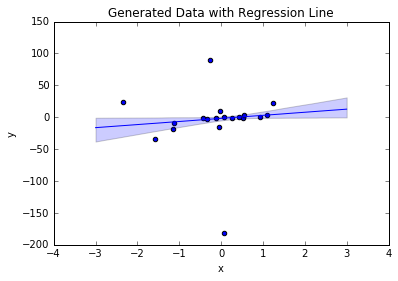

In [110]:
ymed = np.percentile(yxx,   50, axis=0)
ymin = np.percentile(yxx,  2.5, axis=0)
ymax = np.percentile(yxx, 97.5, axis=0)

fig, ax = plt.subplots(1, 1)
ax.set_title('Generated Data with Regression Line')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.scatter(predictors, observations)
reg_line = ax.plot(mx, ymed)
cred_region = ax.fill_between(mx, ymin, ymax, alpha=0.2)
fig.show()